In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
)
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sktime.classification.shapelet_based import ShapeletTransformClassifier
from sktime.transformations.panel.shapelet_transform import RandomShapeletTransform
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from scikitplot.metrics import plot_roc

In [2]:
df = pd.read_csv('./dataset_preprocessed/time_series/time_series.csv')

In [3]:
X = df.drop(columns=['genre']).values
y = df['genre'].values

In [4]:
X = np.reshape(X, (10000, 1, 100))

# Splitting and Normalizing

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size=0.8,
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=0
                                                   )

In [6]:
scaler = TabularToSeriesAdaptor(StandardScaler(), fit_in_transform=True)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# KNN

## With euclidean/manhattan distance

#### 4-Fold CV

In [7]:
%%time

param_grid = {
    'n_neighbors': [4, 8, 16, 32, 64, 128, 256],
    'weights': ['distance', 'uniform'],
    'distance': ['euclidean'],
    'n_jobs': [-1]
}

grid_search = GridSearchCV(
    KNeighborsTimeSeriesClassifier(),
    param_grid=param_grid,
    cv=KFold(n_splits=4, shuffle=True, random_state=42),
    n_jobs=-1,
    refit=True,
    verbose=1,
)

grid_search.fit(X_train_scaled, y_train)
knn_euclidean = grid_search.best_estimator_

Fitting 4 folds for each of 10 candidates, totalling 40 fits
CPU times: user 667 ms, sys: 543 ms, total: 1.21 s
Wall time: 2min 19s


In [8]:
knn_euclidean

KNeighborsTimeSeriesClassifier(distance='euclidean', n_jobs=-1, n_neighbors=8,
                               weights='distance')

In [6]:
knn_euclidean = KNeighborsTimeSeriesClassifier(distance='euclidean', n_jobs=-1, n_neighbors=8, weights='distance')
knn_euclidean.fit(X_train_scaled, y_train)

KNeighborsTimeSeriesClassifier(distance='euclidean', n_jobs=-1, n_neighbors=8,
                               weights='distance')

#### Performances

In [22]:
y_pred = knn_euclidean.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

                   precision    recall  f1-score   support

              emo       0.12      0.05      0.07       100
             folk       0.06      0.04      0.05       100
             goth       0.07      0.04      0.05       100
            happy       0.14      0.38      0.21       100
      heavy-metal       0.13      0.07      0.09       100
       honky-tonk       0.12      0.08      0.10       100
           j-idol       0.09      0.05      0.06       100
             kids       0.11      0.04      0.06       100
   minimal-techno       0.23      0.43      0.30       100
              mpb       0.08      0.02      0.03       100
          new-age       0.07      0.14      0.09       100
            opera       0.07      0.10      0.08       100
            piano       0.15      0.13      0.14       100
progressive-house       0.13      0.33      0.19       100
            salsa       0.14      0.05      0.07       100
        sertanejo       0.09      0.02      0.03       

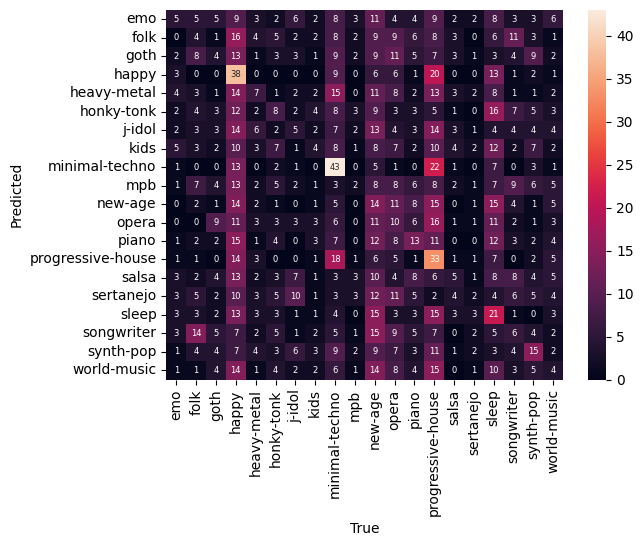

In [23]:
cf = confusion_matrix(y_test, y_pred)

ax= plt.subplot()
sns.heatmap(cf, annot=True, cmap="rocket", fmt='g', annot_kws={"fontsize":6})
ax.xaxis.set_ticklabels(labels=np.sort(np.unique(y)));
ax.yaxis.set_ticklabels(labels=np.sort(np.unique(y)));
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.xlabel("True")
plt.ylabel("Predicted")

plt.savefig('./img/TS Classification/knn_euclidean_confusion_matrix.png', dpi=300, bbox_inches='tight')

plt.show()

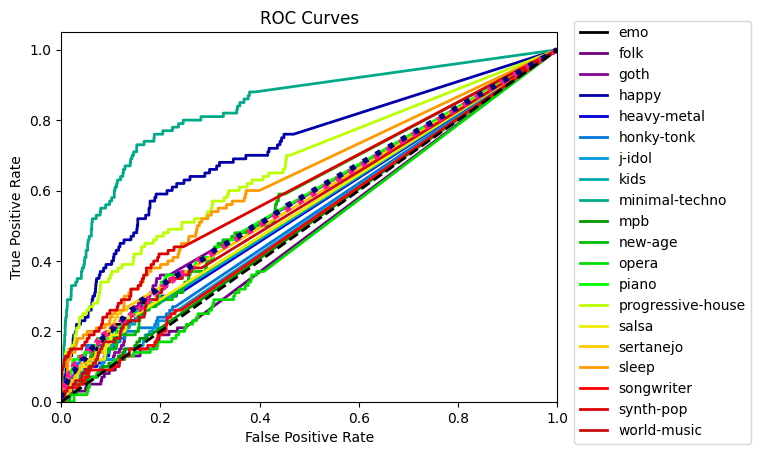

In [24]:
y_test_pred_proba = knn_euclidean.predict_proba(X_test_scaled) 
plot_roc(y_test, y_test_pred_proba)
plt.legend(labels = np.sort(np.unique(y)), bbox_to_anchor=(1.02, 1.05))

plt.savefig('./img/TS Classification/knn_euclidean_roc_curve.png', dpi=300, bbox_inches='tight')

plt.show()

## With Dynamic Time Warping

#### 4-Fold CV

In [15]:
%%time

dist_params = {'window': 0.05}

param_grid = {
    'n_neighbors': [4, 8, 16, 32, 64, 128, 256],
    'weights': ['distance', 'uniform'],
    'distance': ['dtw'],
    'distance_params': [dist_params],
    'n_jobs': [-1]
}

grid_search = GridSearchCV(
    KNeighborsTimeSeriesClassifier(),
    param_grid=param_grid,
    cv=KFold(n_splits=4, shuffle=True, random_state=42),
    n_jobs=-1,
    refit=True,
    verbose=1,
)

grid_search.fit(X_train_scaled, y_train)
knn_dtw = grid_search.best_estimator_

Fitting 4 folds for each of 14 candidates, totalling 56 fits


CPU times: user 7.53 s, sys: 3.74 s, total: 11.3 s
Wall time: 1h 12min 57s


In [16]:
knn_dtw

KNeighborsTimeSeriesClassifier(distance_params={'window': 0.05}, n_jobs=-1,
                               n_neighbors=256, weights='distance')

In [7]:
knn_dtw = KNeighborsTimeSeriesClassifier(distance_params={'window': 0.05}, n_jobs=-1, n_neighbors=256, weights='distance')
knn_dtw.fit(X_train_scaled, y_train)

KNeighborsTimeSeriesClassifier(distance_params={'window': 0.05}, n_jobs=-1,
                               n_neighbors=256, weights='distance')

#### Performances

In [8]:
y_pred = knn_dtw.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

                   precision    recall  f1-score   support

              emo       0.10      0.12      0.11       100
             folk       0.07      0.04      0.05       100
             goth       0.00      0.00      0.00       100
            happy       0.37      0.26      0.30       100
      heavy-metal       0.14      0.06      0.08       100
       honky-tonk       0.30      0.09      0.14       100
           j-idol       0.19      0.08      0.11       100
             kids       0.10      0.16      0.13       100
   minimal-techno       0.37      0.45      0.41       100
              mpb       0.13      0.12      0.13       100
          new-age       0.15      0.38      0.21       100
            opera       0.06      0.01      0.02       100
            piano       0.08      0.19      0.12       100
progressive-house       0.23      0.36      0.28       100
            salsa       0.10      0.08      0.09       100
        sertanejo       0.20      0.36      0.26       

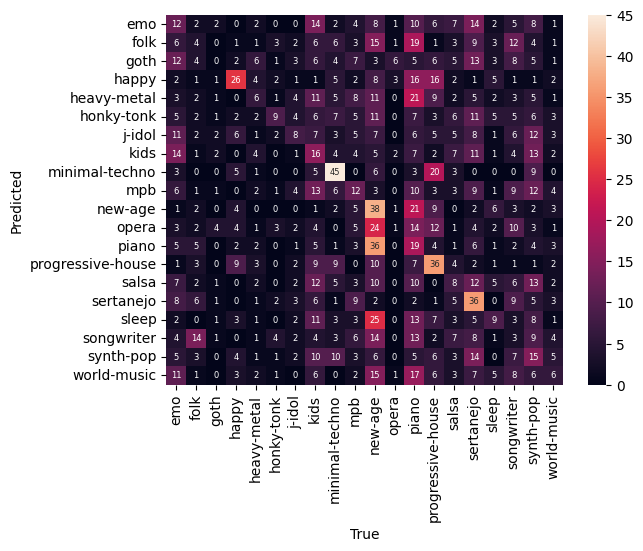

In [27]:
cf = confusion_matrix(y_test, y_pred)

ax= plt.subplot()
sns.heatmap(cf, annot=True, cmap="rocket", fmt='g', annot_kws={"fontsize":6})
ax.xaxis.set_ticklabels(labels=np.sort(np.unique(y)))
ax.yaxis.set_ticklabels(labels=np.sort(np.unique(y)))
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.xlabel("True")
plt.ylabel("Predicted")

plt.savefig('./img/TS Classification/knn_dtw_confusion_matrix.png', dpi=300, bbox_inches='tight')

plt.show()

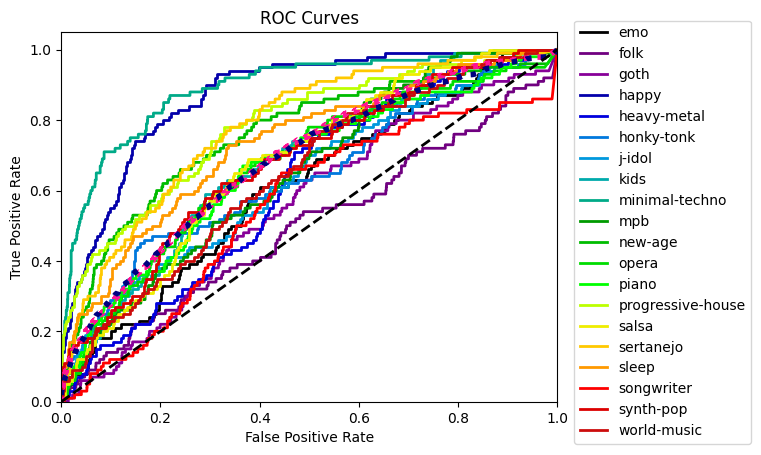

In [28]:
y_test_pred_proba = knn_dtw.predict_proba(X_test_scaled) 
plot_roc(y_test, y_test_pred_proba)
plt.legend(labels = np.sort(np.unique(y)), bbox_to_anchor=(1.02, 1.05))

plt.savefig('./img/TS Classification/knn_dtw_roc_curve.png', dpi=300, bbox_inches='tight')

plt.show()

# Shapelet-based Classification

In [7]:
rst = RandomShapeletTransform(n_shapelet_samples=1000,
                              max_shapelets=200,
                              min_shapelet_length=4,
                              max_shapelet_length=16,
                              n_jobs=-1,
                              )

In [8]:
%%time
rst.fit(X_train, y_train)

CPU times: user 5h 53min 15s, sys: 7min 45s, total: 6h 1min
Wall time: 5h 54min 56s


RandomShapeletTransform(max_shapelet_length=16, max_shapelets=200,
                        min_shapelet_length=4, n_jobs=-1,
                        n_shapelet_samples=1000)

In [9]:
%%time
shapelets_distances_train = rst.transform(X_train)
shapelets_distances_test = rst.transform(X_test)

CPU times: user 2min 14s, sys: 27.5 s, total: 2min 41s
Wall time: 3min 13s


In [16]:
# Saving everything 
# np.save('./dataset_preprocessed/time_series/shapelets.npy', np.array(rst.shapelets, dtype=object))
# 
# np.save('./dataset_preprocessed/time_series/shapelets_distances_train.npy', shapelets_distances_train)
# np.save('./dataset_preprocessed/time_series/shapelets_distances_test.npy', shapelets_distances_test)

In [7]:
shapelets_distances_train = np.load('./dataset_preprocessed/time_series/shapelets_distances_train.npy', allow_pickle=True)
shapelets_distances_test = np.load('./dataset_preprocessed/time_series/shapelets_distances_test.npy', allow_pickle=True)

In [17]:
%%time

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [8, 16, 32, 64, 128, 256, 512] + [None],
    'min_samples_split': [4, 8, 16, 32, 64, 128, 256],
    'min_samples_leaf': [4, 8, 16, 32, 64, 128, 256],
}

grid_search = GridSearchCV(
    DecisionTreeClassifier(),
    param_grid=param_grid,
    cv=KFold(n_splits=4, shuffle=True, random_state=42),
    n_jobs=-1,
    refit=True,
    verbose=1
)

grid_search.fit(shapelets_distances_train, y_train)
dec_tree = grid_search.best_estimator_

Fitting 4 folds for each of 784 candidates, totalling 3136 fits
CPU times: user 13.9 s, sys: 2.53 s, total: 16.4 s
Wall time: 38min 15s


In [18]:
dec_tree

DecisionTreeClassifier(max_depth=16, min_samples_leaf=4, min_samples_split=128)

In [8]:
dec_tree = DecisionTreeClassifier(max_depth=16, min_samples_leaf=4, min_samples_split=128, criterion='gini')
dec_tree.fit(shapelets_distances_train, y_train)

DecisionTreeClassifier(max_depth=16, min_samples_leaf=4, min_samples_split=128)

#### Performances

In [9]:
y_pred = dec_tree.predict(shapelets_distances_test)
print(classification_report(y_test, y_pred))

                   precision    recall  f1-score   support

              emo       0.09      0.19      0.12       100
             folk       0.05      0.07      0.06       100
             goth       0.06      0.04      0.05       100
            happy       0.14      0.14      0.14       100
      heavy-metal       0.10      0.18      0.13       100
       honky-tonk       0.09      0.04      0.06       100
           j-idol       0.07      0.07      0.07       100
             kids       0.10      0.13      0.11       100
   minimal-techno       0.48      0.43      0.45       100
              mpb       0.04      0.04      0.04       100
          new-age       0.26      0.29      0.27       100
            opera       0.14      0.14      0.14       100
            piano       0.09      0.07      0.08       100
progressive-house       0.16      0.13      0.14       100
            salsa       0.09      0.07      0.08       100
        sertanejo       0.11      0.14      0.12       

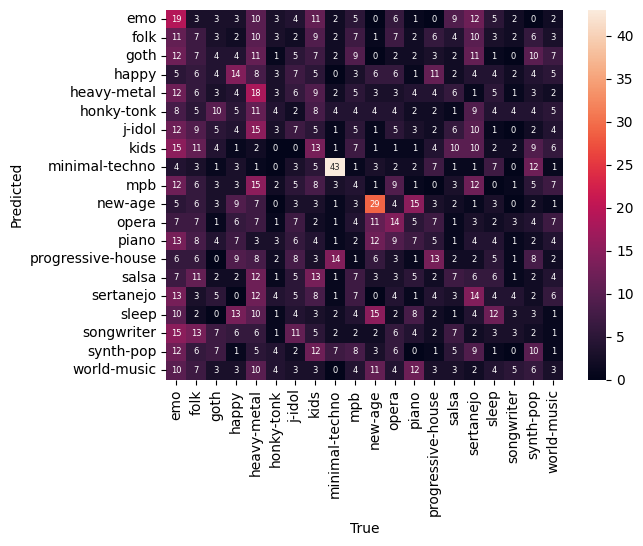

In [10]:
cf = confusion_matrix(y_test, y_pred)

ax= plt.subplot()
sns.heatmap(cf, annot=True, cmap="rocket", fmt='g', annot_kws={"fontsize":6})
ax.xaxis.set_ticklabels(labels=np.sort(np.unique(y)))
ax.yaxis.set_ticklabels(labels=np.sort(np.unique(y)))
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.xlabel("True")
plt.ylabel("Predicted")

plt.savefig('./img/TS Classification/shapelets_confusion_matrix.png', dpi=300, bbox_inches='tight')

plt.show()

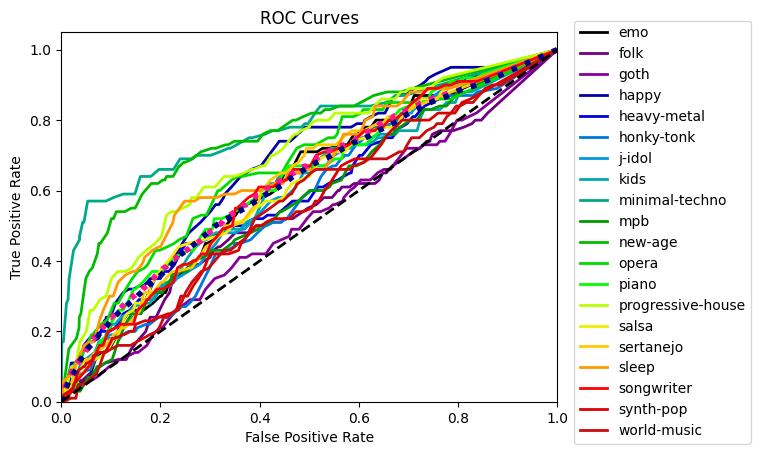

In [11]:
y_test_pred_proba = dec_tree.predict_proba(shapelets_distances_test) 
plot_roc(y_test, y_test_pred_proba)
plt.legend(labels = np.sort(np.unique(y)), bbox_to_anchor=(1.02, 1.05))

plt.savefig('./img/TS Classification/shapelets_roc_curve.png', dpi=300, bbox_inches='tight')

plt.show()

# Others

Comparing a "real" CNN with ROCKET

## Convolutional Neural Network

CNN with 3 convolutional layers + 1 dense layer, 16+32+16+20 units

In [7]:
import keras
from keras import models, layers, optimizers, callbacks
from keras.regularizers import l2, l1
from scikeras.wrappers import KerasClassifier

2024-06-12 17:11:12.532431: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
# Reshaping the input
X_train_cnn = np.swapaxes(X_train_scaled, 1, 2)
X_test_cnn = np.swapaxes(X_test_scaled, 1, 2)

In [9]:
# One-hot-encoding the target with sklearn
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

y_train_ohe = enc.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test_ohe = enc.transform(y_test.reshape(-1, 1)).toarray()


In [10]:
def my_cnn(activation, lr, penalty, opt):
    model = models.Sequential()
    
    model.add(layers.Conv1D(
        filters=16,
        kernel_size=16,
        activation=activation,
        kernel_regularizer=l2(penalty),
        input_shape=(100, 1)
        ))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv1D(
        filters=32,
        kernel_size=16,
        activation=activation,
        kernel_regularizer=l2(penalty)
        ))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv1D(
        filters=16,
        kernel_size=16,
        activation=activation,
        kernel_regularizer=l2(penalty)
        ))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.GlobalAveragePooling1D())

    model.add(layers.Flatten())    
    model.add(layers.Dense(20, activation='sigmoid')) 

    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        lr,
        decay_steps=100,
        decay_rate=0.95,
        staircase=True)
    
    if opt == 'sgd':
        optimizer=optimizers.SGD(learning_rate=lr_schedule)
    else:
        optimizer=optimizers.Adam(learning_rate=lr_schedule)     

    

    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,        
        metrics=['accuracy']
    )
    return model

In [11]:
cnn = KerasClassifier(model=my_cnn(opt='adam', lr=0.001, activation='sigmoid', penalty=0.01),
                      random_state=0,
                      callbacks=[callbacks.EarlyStopping(patience=10, min_delta=0.001), callbacks.ModelCheckpoint('best_model_NOREG.keras', monitor='val_loss', save_best_only=True)])

cnn.fit(X_train_cnn, y_train_ohe, epochs=100, validation_split=0.2)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.0581 - loss: 3.3440 - val_accuracy: 0.0475 - val_loss: 3.1465
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.0626 - loss: 3.0977 - val_accuracy: 0.0475 - val_loss: 3.3057
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.0974 - loss: 2.9954 - val_accuracy: 0.0475 - val_loss: 3.9289
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.1185 - loss: 2.8988 - val_accuracy: 0.0763 - val_loss: 2.9712
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.1346 - loss: 2.8504 - val_accuracy: 0.1275 - val_loss: 2.8520
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.1454 - loss: 2.8141 - val_accuracy: 0.1300 - val_loss: 2.8409
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.1484 - loss: 2.7934 - val_accuracy: 0.1394 - val_loss: 2.8210
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.1522 - loss: 2.7744 - 

KerasClassifier(
	model=<Sequential name=sequential, built=True>
	build_fn=None
	warm_start=False
	random_state=0
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=[<keras.src.callbacks.early_stopping.EarlyStopping object at 0x14941aa50>, <keras.src.callbacks.model_checkpoint.ModelCheckpoint object at 0x1493ea410>]
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	class_weight=None
)

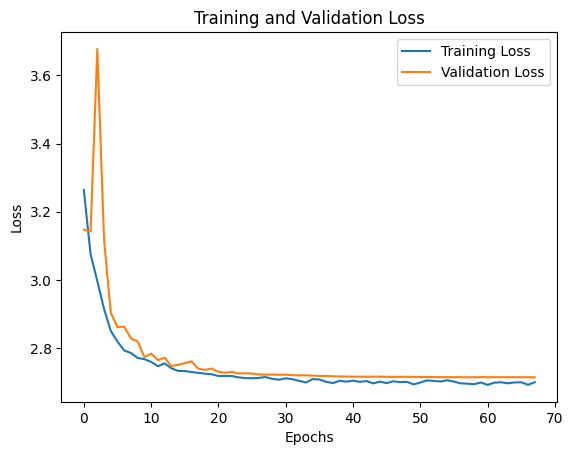

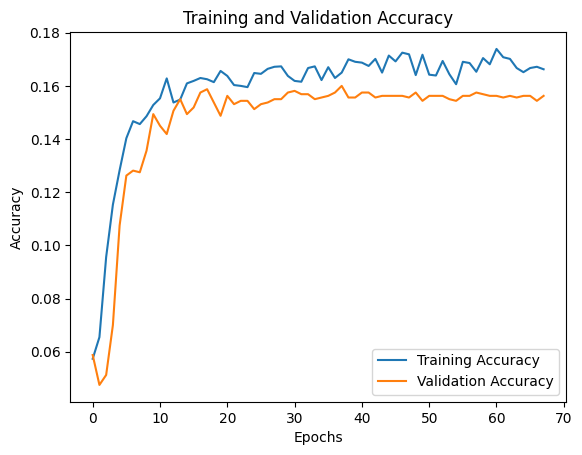

In [23]:
# Plot training and validation loss
plt.plot(cnn.history_['loss'], label='Training Loss')
plt.plot(cnn.history_['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.savefig('./img/TS Classification/cnn_loss.png', dpi=300, bbox_inches='tight')

plt.show()

# Plot training and validation accuracy
plt.plot(cnn.history_['accuracy'], label='Training Accuracy')
plt.plot(cnn.history_['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.savefig('./img/TS Classification/cnn_accuracy.png', dpi=300, bbox_inches='tight')

plt.show()

In [24]:
y_pred = cnn.predict(X_test_cnn)
print(classification_report(y_test_ohe, y_pred, target_names=np.sort(np.unique(y))))

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
                   precision    recall  f1-score   support

              emo       0.17      0.14      0.15       100
             folk       0.07      0.01      0.02       100
             goth       0.05      0.01      0.02       100
            happy       0.21      0.49      0.30       100
      heavy-metal       0.14      0.03      0.05       100
       honky-tonk       0.08      0.03      0.04       100
           j-idol       0.50      0.02      0.04       100
             kids       0.13      0.13      0.13       100
   minimal-techno       0.47      0.65      0.55       100
              mpb       0.09      0.03      0.04       100
          new-age       0.21      0.56      0.30       100
            opera       0.06      0.01      0.02       100
            piano       0.04      0.03      0.04       100
progressive-house       0.30      0.28      0.29       100
            salsa       0.13      0.21      0.16       100
        sertanej

In [25]:
# Accuracy is 0.17

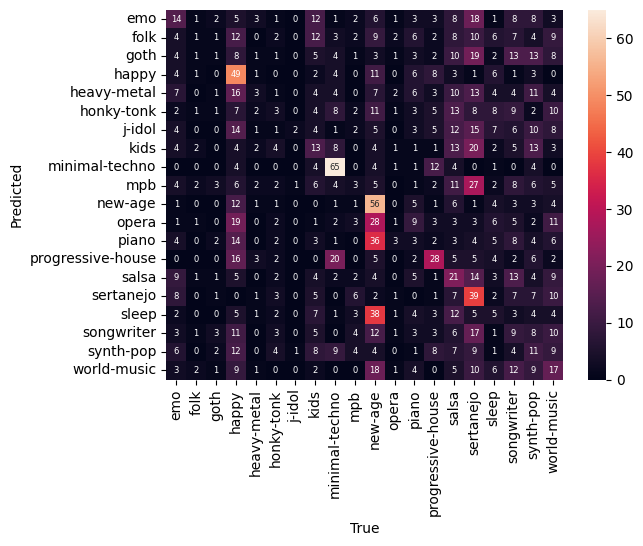

In [26]:
y_test_unenc = enc.inverse_transform(y_test_ohe)
y_pred_unenc = enc.inverse_transform(y_pred)

cf = confusion_matrix(y_test_unenc, y_pred_unenc)

ax= plt.subplot()
sns.heatmap(cf, annot=True, cmap="rocket", fmt='g', annot_kws={"fontsize":6})
ax.xaxis.set_ticklabels(labels=np.sort(np.unique(y)));
ax.yaxis.set_ticklabels(labels=np.sort(np.unique(y)));
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.xlabel("True")
plt.ylabel("Predicted")

plt.savefig('./img/TS Classification/cnn_confusion_matrix.png', dpi=300, bbox_inches='tight')

plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


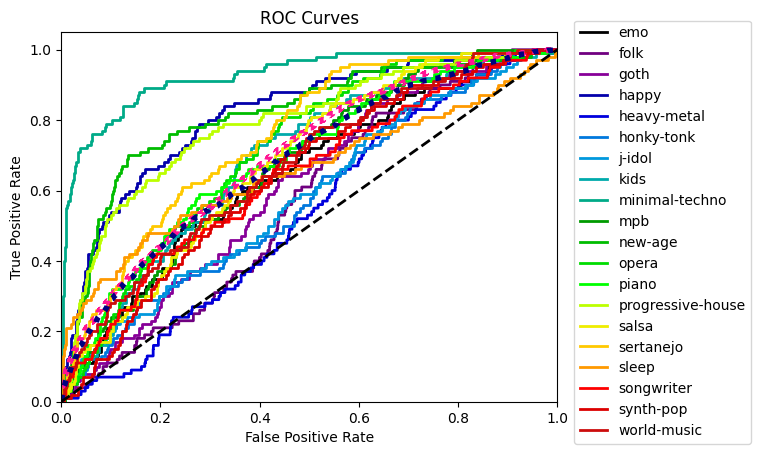

In [27]:
y_test_pred_proba = cnn.predict_proba(X_test_cnn) 
plot_roc(y_test_unenc, y_test_pred_proba)
plt.legend(labels = np.sort(np.unique(y)), bbox_to_anchor=(1.02, 1.05))

plt.savefig('./img/TS Classification/cnn_roc.png', dpi=300, bbox_inches='tight')

plt.show()

In [28]:
param_distributions = {
    'model__opt': ['adam'],
    'model__lr': [0.1, 0.01, 0.001],
    'model__activation': ['relu', 'tanh', 'sigmoid'],
    'model__penalty': [0.1, 0.01, 0.001],
    'epochs': [100, 500, 1000]
}

random_search = RandomizedSearchCV(
    estimator=KerasClassifier(model=my_cnn),
    param_distributions=param_distributions,
    scoring='accuracy',
    n_iter=10,
    cv=KFold(n_splits=4, shuffle=True, random_state=42),
    n_jobs=-1,
    refit=True,
    verbose=1
)

random_search.fit(X_train_cnn, y_train_ohe)
cnn = random_search.best_estimator_

Fitting 4 folds for each of 10 candidates, totalling 40 fits


KeyboardInterrupt: 

## ROCKET

In [6]:
from sktime.classification.kernel_based import RocketClassifier

In [39]:
%%time

param_grid = {
    'rocket_transform': ['minirocket'],
    'num_kernels': [1000, 2000, 4000, 8000],
    'max_dilations_per_kernel': [8, 16, 32, 64],
    'n_jobs': [-1],
}

grid_search = GridSearchCV(
    RocketClassifier(),
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=4, shuffle=True, random_state=42),
    n_jobs=-1,
    refit=True,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)
rocket = grid_search.best_estimator_

Fitting 4 folds for each of 16 candidates, totalling 64 fits
CPU times: user 17.2 s, sys: 7.06 s, total: 24.3 s
Wall time: 20min 25s


In [40]:
rocket

RocketClassifier(max_dilations_per_kernel=64, n_jobs=-1, num_kernels=1000,
                 rocket_transform='minirocket')

In [11]:
rocket = RocketClassifier(n_jobs=-1, num_kernels=1000, max_dilations_per_kernel=64, rocket_transform='minirocket')
rocket.fit(X_train_scaled, y_train)

RocketClassifier(max_dilations_per_kernel=64, n_jobs=-1, num_kernels=1000,
                 rocket_transform='minirocket')

#### Performances

In [12]:
y_pred = rocket.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

                   precision    recall  f1-score   support

              emo       0.08      0.05      0.06       100
             folk       0.06      0.03      0.04       100
             goth       0.14      0.04      0.06       100
            happy       0.34      0.65      0.44       100
      heavy-metal       0.08      0.05      0.06       100
       honky-tonk       0.16      0.15      0.16       100
           j-idol       0.05      0.03      0.04       100
             kids       0.23      0.23      0.23       100
   minimal-techno       0.43      0.69      0.53       100
              mpb       0.09      0.06      0.07       100
          new-age       0.21      0.34      0.26       100
            opera       0.20      0.22      0.21       100
            piano       0.11      0.08      0.09       100
progressive-house       0.31      0.34      0.33       100
            salsa       0.19      0.31      0.24       100
        sertanejo       0.20      0.24      0.22       

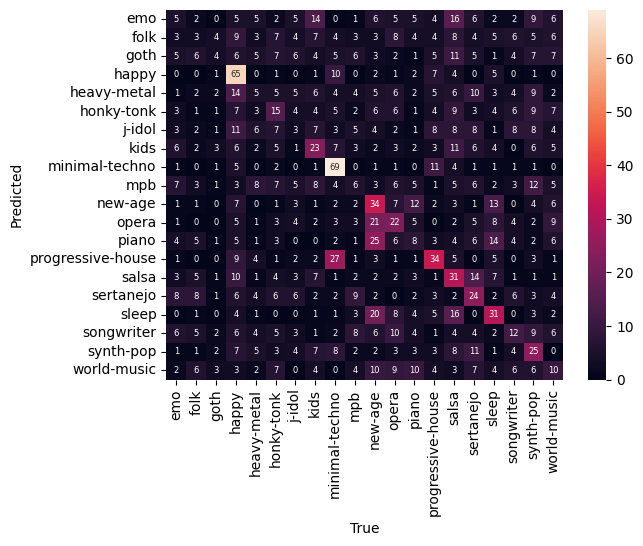

In [13]:
cf = confusion_matrix(y_test, y_pred)

ax= plt.subplot()
sns.heatmap(cf, annot=True, cmap="rocket", fmt='g', annot_kws={"fontsize":6})
ax.xaxis.set_ticklabels(labels=np.sort(np.unique(y)));
ax.yaxis.set_ticklabels(labels=np.sort(np.unique(y)));
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.xlabel("True")
plt.ylabel("Predicted")

plt.savefig('./img/TS Classification/rocket_confusion_matrix.png', dpi=300, bbox_inches='tight')

plt.show()

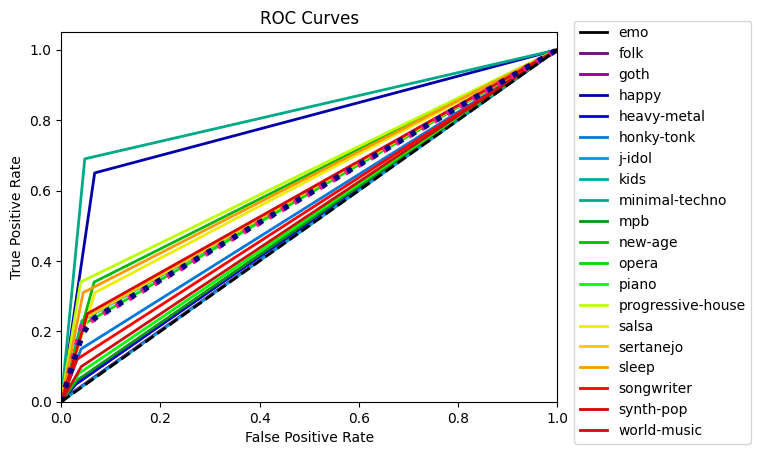

In [14]:
y_test_pred_proba = rocket.predict_proba(X_test_scaled) 
plot_roc(y_test, y_test_pred_proba)
plt.legend(labels = np.sort(np.unique(y)), bbox_to_anchor=(1.02, 1.05))

plt.savefig('./img/TS Classification/rocket_roc_curve.png', dpi=300, bbox_inches='tight')

plt.show()